In [1]:
import os
os.chdir('G:/My Drive/Reyhan_Research/Research IV-DNN/revision/revision/rev2/github_final')
import utils as utils
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat
from scipy.stats import gaussian_kde
from tensorflow import keras

from tabulate import tabulate
import tensorflow as tf
from tensorflow.keras import backend as K


In [2]:
# Defining the class for focal loss function.

# This is necessary for loading the estimation models
class CategoricalFocalLoss(tf.keras.losses.Loss):

        def __init__(self, alpha, gamma):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma

        def call(self, y_true, y_pred):

            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
            cross_entropy = -y_true * K.log(y_pred)
            loss = self.alpha * K.pow(1 - y_pred, self.gamma) * cross_entropy
            return K.mean(K.sum(loss, axis=-1))

In [3]:
# Below is the subset of ocean dataframe to test the trained models
# This is 20% of the originl testset
path = 'G:/My Drive/Reyhan_Research/Research IV-DNN/revision/revision/rev2/github_final/'
surf_type = 'ocean'
data = pd.read_csv(os.path.join(path, f'data/{surf_type}_subset_rev4.csv'))
X_tst, y_tst = utils.process_and_normalize(data, surf_type)

In [4]:
# The models are loaded here

path_models   = os.path.join(path, 'models/')
path_features = os.path.join(path, 'features/')

model_dtc_xgb = pickle.load(open((path_models+f'{surf_type}_det_xgb_rev4.pickle.dat'), "rb"))

# model_dtc_dnn = keras.models.load_model(path_models + f"{surf_type}_det_dnn_2.h5")

model_rtv_rain = keras.models.load_model(path_models + f'{surf_type}_est_FL_rain_10class_rev2.keras',\
                                                   custom_objects={'CategoricalFocalLoss': utils.CategoricalFocalLoss(alpha=0.25, gamma=2)}, compile=False)

model_rtv_snow = keras.models.load_model(path_models + f'{surf_type}_est_FL_snow_10class_rev2.keras',\
                                                  custom_objects={'CategoricalFocalLoss': utils.CategoricalFocalLoss(alpha=0.25, gamma=2)}, compile=False)

features_data = sio.loadmat(path_features + f'feature_dic_{surf_type}_rev2.mat')
X_trn_rain_features = features_data[f'X_trn_rain_features_{surf_type}']
y_trn_rain = features_data[f'y_train_rain_{surf_type}'][:,1]

X_trn_snow_features = features_data[f'X_trn_snow_features_{surf_type}']
y_trn_snow = features_data[f'y_train_snow_{surf_type}'][:,1]
# warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')

In [5]:
# print more scores
prd_xgb = model_dtc_xgb.predict(X_tst)

utils.classification_score(y_tst[:,0], prd_xgb)

+----------+--------+--------+
| Metric   |   Rain |   Snow |
+==========+========+========+
| TPR      |  0.958 |  0.974 |
+----------+--------+--------+
| FPR      |  0.014 |  0.006 |
+----------+--------+--------+
| AUC      |  0.972 |  0.984 |
+----------+--------+--------+
| F1 Score |  0.956 |  0.951 |
+----------+--------+--------+


(0.0, 1.0, 0.0, 1.0)

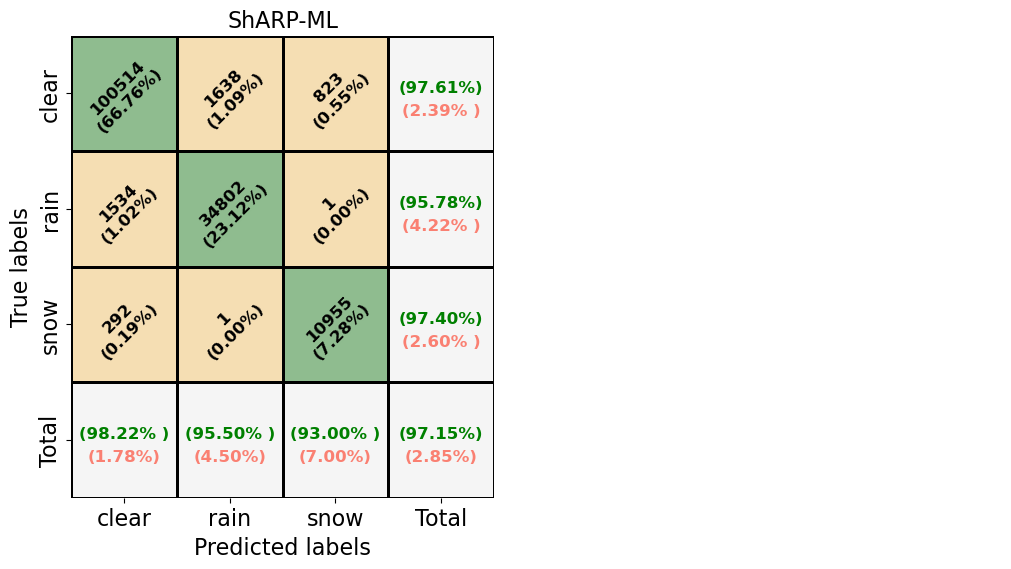

In [6]:
# plot the confusion matrix
fig, axes = plt.subplots(1,2,figsize=(12, 6))
axes = axes.ravel()
utils.plot_detailed_confusion_matrix(y_tst[:,0], prd_xgb, axes[0], 'ShARP-ML', True, True)
axes[1].axis('off')


### Estimation using ShARP_ML

In [7]:
# # Getting the features on the one to last layer


new_input_rain   = model_rtv_rain.layers[0].input
new_output_rain  = model_rtv_rain.get_layer('fc_3').output
model_rtv_rain_ = tf.keras.Model(new_input_rain, new_output_rain)

new_input_snow   = model_rtv_snow.layers[0].input
new_output_snow  = model_rtv_snow.get_layer('fc_3').output
model_rtv_snow_ = tf.keras.Model(new_input_snow, new_output_snow)


In [8]:
feature_prd_snow = model_rtv_snow_.predict(X_tst)
feature_prd_rain = model_rtv_rain_.predict(X_tst)

4705/4705 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step
4705/4705 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step


In [9]:
k_nn_rain, k_nn_snow = 20, 20
rate_rain_pred_knn, indices_rain = utils.rate_knn(X_trn_rain_features, feature_prd_rain, y_trn_rain, k_nn_rain)
rate_snow_pred_knn, indices_snow = utils.rate_knn(X_trn_snow_features, feature_prd_snow, y_trn_snow, k_nn_snow)

rate_rain_pred_ridge = utils.ridge_estimation(
    X_trn_rain_features, feature_prd_rain, indices_rain, y_trn_rain, rate_rain_pred_knn
    )

rate_snow_pred_ridge = utils.ridge_estimation(
    X_trn_snow_features, feature_prd_snow, indices_snow, y_trn_snow, rate_snow_pred_knn
    )


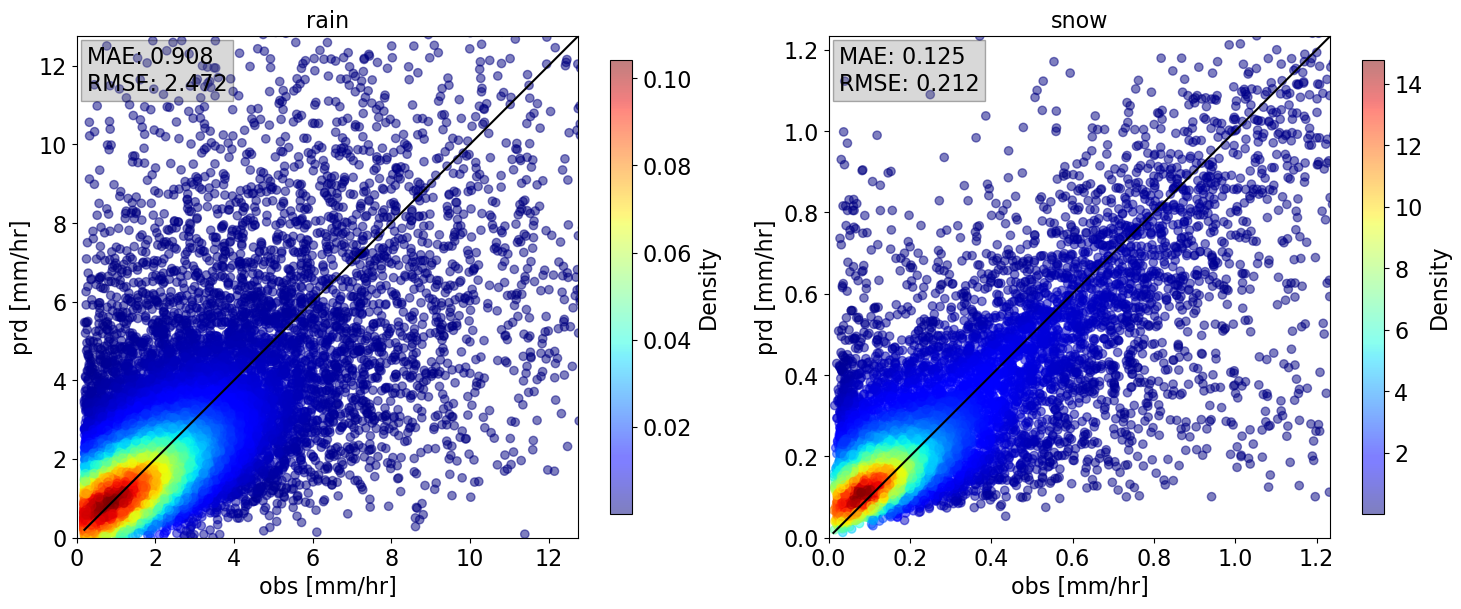

In [10]:
# The result are different from the paper since testset is 20% of the original testset
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plt.rcParams.update({'font.size': 16})
# Call the plot function for each subplot
utils.plot_density_scatter(axes[0], y_tst, rate_rain_pred_ridge, prd_xgb, 1, 0)
utils.plot_density_scatter(axes[1], y_tst, rate_snow_pred_ridge, prd_xgb, 2, 0)
axes[0].set_title('rain')
axes[1].set_title('snow')

plt.tight_layout()
plt.show()

## Orbital retrieval

In [19]:
path = 'G:/My Drive/Reyhan_Research/Research IV-DNN/revision/revision/rev2/github_rev2/'
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
from scipy import io
import glob

In [20]:

# Function to load feature data
def load_feature_data():
    # path_features = '/panfs/jay/groups/0/ebtehaj/rahim035/sajad_s/project-4/revision/features/'
    path_features = os.path.join(path,'features/')
    features_data = {
        'ocean': {
            'X_trn_rain_features_ocean': sio.loadmat(path_features + 'feature_dic_ocean_rev2.mat')['X_trn_rain_features_ocean'],
            'y_trn_rain_ocean': sio.loadmat(path_features + 'feature_dic_ocean_rev2.mat')['y_train_rain_ocean'],
            'X_trn_snow_features_ocean': sio.loadmat(path_features + 'feature_dic_ocean_rev2.mat')['X_trn_snow_features_ocean'],
            'y_trn_snow_ocean': sio.loadmat(path_features + 'feature_dic_ocean_rev2.mat')['y_train_snow_ocean']
        },
        'land': {
            'X_trn_rain_features_land': sio.loadmat(path_features + 'feature_dic_land_rev2.mat')['X_trn_rain_features_land'],
            'y_trn_rain_land': sio.loadmat(path_features + 'feature_dic_land_rev2.mat')['y_train_rain_land'],
            'X_trn_snow_features_land': sio.loadmat(path_features + 'feature_dic_land_rev2.mat')['X_trn_snow_features_land'],
            'y_trn_snow_land': sio.loadmat(path_features + 'feature_dic_land_rev2.mat')['y_train_snow_land']
        },
        'coast': {
            'X_trn_rain_features_coast': sio.loadmat(path_features + 'feature_dic_coast_rev2.mat')['X_trn_rain_features_coast'],
            'y_trn_rain_coast': sio.loadmat(path_features + 'feature_dic_coast_rev2.mat')['y_train_rain_coast'],
            'X_trn_snow_features_coast': sio.loadmat(path_features + 'feature_dic_coast_rev2.mat')['X_trn_snow_features_coast'],
            'y_trn_snow_coast': sio.loadmat(path_features + 'feature_dic_coast_rev2.mat')['y_train_snow_coast']
        },
        'snow': {
            'X_trn_rain_features_snow': sio.loadmat(path_features + 'feature_dic_snowcover_rev2.mat')['X_trn_rain_features_snowcover'],
            'y_trn_rain_snow': sio.loadmat(path_features + 'feature_dic_snowcover_rev2.mat')['y_train_rain_snowcover'],
            'X_trn_snow_features_snow': sio.loadmat(path_features + 'feature_dic_snowcover_rev2.mat')['X_trn_snow_features_snowcover'],
            'y_trn_snow_snow': sio.loadmat(path_features + 'feature_dic_snowcover_rev2.mat')['y_train_snow_snowcover']
        },
        'ice': {
            'X_trn_rain_features_ice': sio.loadmat(path_features + 'feature_dic_seaice_rev2.mat')['X_trn_rain_features_seaice'],
            'y_trn_rain_ice': sio.loadmat(path_features + 'feature_dic_seaice_rev2.mat')['y_train_rain_seaice'],
            'X_trn_snow_features_ice': sio.loadmat(path_features + 'feature_dic_seaice_rev2.mat')['X_trn_snow_features_seaice'],
            'y_trn_snow_ice': sio.loadmat(path_features + 'feature_dic_seaice_rev2.mat')['y_train_snow_seaice']
        }
    }
    return features_data

In [21]:
def orbit_retreival(orbit_number):
    models = utils.load_models()
    features_data = load_feature_data()
    stats = utils.load_stats()

    my_files = glob.glob(path + f'/orbital/*{orbit_number}_dics.mat')
    orbit_num = my_files[0][-14:-9]
    X_normalized = utils.preprocess_input_data(my_files[0], stats)
    predictions = utils.predict_features(models, X_normalized)
    localized_rates = utils.localize_retrievals(predictions, features_data, k_nn_rain=20, k_nn_snow=20)
    X_rain, X_snow, X_precip_label, Lat, Lon = utils.reconstruct_orbit(localized_rates, orbit_num)

    print(f"Orbit Number: {orbit_num}")

    return X_rain, X_snow, X_precip_label, Lat, Lon


In [22]:
X_rain, X_snow, X_precip_label, Lat, Lon = orbit_retreival('03080')
idx_rain = X_precip_label == 1
idx_snow = X_precip_label == 2
X_rain[~idx_rain] = 0
X_snow[~idx_snow] = 0


20450/20450 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step
20450/20450 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step
Orbit Number: 03080


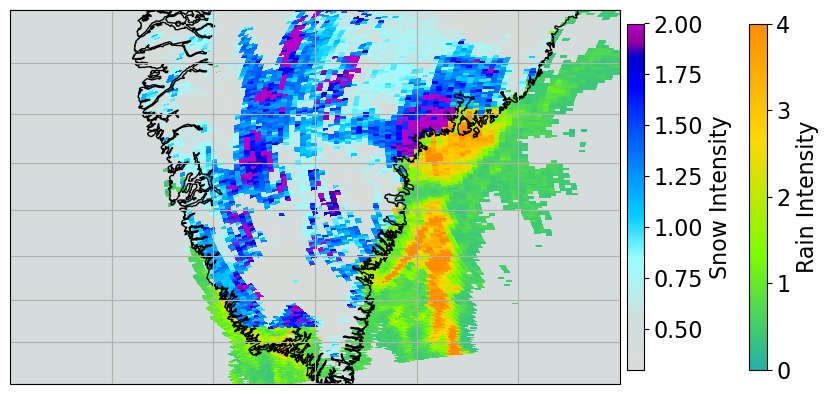

In [38]:
# Define zones and calculate the image ratio
zones = [-60, -30, 60, 68]
level = 10
im_ratio = X_rain.shape[0] / X_rain.shape[1]
X_rain_masked = np.ma.masked_where(X_rain == 0, X_rain)
X_snow_masked = np.ma.masked_where(X_snow == 0, X_snow)
cmap_rain, cmap_snow = utils.load_colormaps(path + f'/data/colormap.mat')

# Create a figure with one subplot using the Mercator projection
fig, ax3 = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})

# Plot rain data
rain_plot = ax3.pcolormesh(
    Lon,
    Lat,
    X_rain_masked,
    cmap=cmap_rain,
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=4,
)

# Plot snow data
snow_plot = ax3.pcolormesh(
    Lon,
    Lat,
    X_snow_masked,
    cmap=cmap_snow,
    transform=ccrs.PlateCarree(),
    vmin=0.3,
    vmax=2,
)

# Add coastlines and gridlines
ax3.coastlines()
ax3.gridlines(draw_labels=False)

# Set the extent of the plot
ax3.set_extent(zones, ccrs.PlateCarree())

# Add colorbars for rain and snow
cbar_rain = fig.colorbar(rain_plot, ax=ax3, orientation='vertical', fraction=0.046, pad=0.12, shrink = 0.45)
cbar_rain.set_label('Rain Intensity')

cbar_snow = fig.colorbar(snow_plot, ax=ax3, orientation='vertical', fraction=0.046, pad=0.01, shrink = 0.45)
cbar_snow.set_label('Snow Intensity')

plt.show()


## Appendix

### Parameter tuning of XGBDT

In [39]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

def tune_xgb_hyperparameters(X_trn, y_trn):
    """
    Perform hyperparameter tuning for an XGBoost classifier using SMOTE for oversampling the minority class.

    Parameters:
    X_trn (pd.DataFrame or np.ndarray): Training features.
    y_trn (pd.Series or np.ndarray): Training labels.

    Returns:
    dict: Best hyperparameters found by the RandomizedSearchCV.
    """

    # Define the XGBoost model
    model_xgb = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

    # Define the hyperparameters grid
    param_grid = {
        'max_depth': [15, 20, 25],
        'learning_rate': [0.01, 0.3],
        'n_estimators': [100, 200, 300],
        'min_child_weight': [1, 5, 10],
    }

    # Define a scoring function (F1-score with macro averaging)
    scorer = make_scorer(f1_score, average='macro')

    # Set up Randomized Search
    grid_search = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1, n_iter=10)

    # Fit the grid search
    grid_search.fit(X_trn,  y_trn[:, 0])

    # Print the best parameters
    print("Best parameters found: ", grid_search.best_params_)

    return grid_search.best_params_